# Assignment 3: Text processing with LSTM in PyTorch


In this assignment you will a train an LSTM to generate text. To be able to feed text into (recurrent) neural networks we first have to choose a good representation. There are several options to do so ranging from simple character embeddings to more sophisticated approaches like [word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) or [token embeddings](https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a). We will use a character embedding in this assignment. 

Character embeddings work as follows. First we define an alphabet, a set of characters that we want to be able to represent. To feed a character into our network we use a one-hot vector. The dimension of this vector is equal to the size of our alphabet and the "hot" position indicates the character we want to represent. While this is logically a decent representation (all characters have the same norm, are orthogonal to one another, etc.) it is inefficient in terms of memory because we have to store a lot of zeros. In the first layer of our network we will multiply our one-hot vector with a weight matrix, i.e. we compute the preactivation by a matrix-vector product of the form $We_i$, where $e_i$ is the $i$-th canonical basis vector. This operation corresponds to selecting the $i$-th column of $W$. So an efficient implementation is to perform a simple lookup operation in $W$. This is how embedding layers work also for word or token embeddings. They are learnable lookup tables. 

## Exercise 1: Encoding characters

Write a class `Encoder` that implements the methods `__init__` and `__call__`. The method `__init__` takes a string as argument that serves as alphabet. The method `__call__` takes one argument. If it is a string then it should return a sequence of integers as `torch.Tensor` of shape  representing the input string. Each integer should represents a character of the alphabet. The alphabet consists of the characters matched by the regex `[a-z0-9 .!?]`. If the input text contains characters that are not in the alphabet, then `__call__` should either remove them or map them to a corresponding character that belongs to the alphabet. If the argument is a `torch.Tensor`, then the method should return a string representation of the input, i.e. it should function as decoder. 

In [6]:
import re
import torch

########## YOUR SOLUTION HERE ##########
class Encoder:
    
    def __init__(self, alphabet: str):
        self.alphabet = alphabet
        pass
    
    def __call__(self, argument):

      # create dictionary containing the characters as keys and the integers as values:
        alpha_dict = dict()
        for i, key in zip(range(len(self.alphabet)),self.alphabet):
            alpha_dict[key] = i

            
        if type(argument) == str:

            # create the list/torch in which the characters are stored as ints:
            int_list = []
            for chara in argument:
                chara = chara.lower() # alphabet only considers lower letters!
                if chara in alpha_dict:
                    found_int = alpha_dict[chara]
                    int_list.append(found_int)
                else:
                    int_list.append(len(self.alphabet)) # character is not contained in alphabet 
                    # -1 not usable for the torch.nn.Embedding, therfore use positive int

            final_torch = torch.tensor(int_list)
            return final_torch


        elif type(argument) == torch.Tensor:

            # reverse keys values in alpha_dict:
            alpha_dict_rev = dict(zip(alpha_dict.values(),alpha_dict.keys()))


            #decode stuff: from ints to characters (return string):
            chara_list = []
            for torch_integer in argument:
                integer = int(torch_integer)

                if integer in alpha_dict_rev:
                    found_chara = alpha_dict_rev[integer]
                    chara_list.append(found_chara)

                else:
                    chara_list.append('~')

            final_string = ''.join(chara_list)  
            return final_string
 

## Exercise 2: Pytorch Dataset

Write a class `TextDataset` that derives from `torch.utlis.data.Dataset`. It should wrap a text file and utilize it for training with pytorch. Implement the methods `__init__`, `__len__`, `__getitem__`. The method `__init__` should take a path to a text file as string and an integer `l` specifying the length of one sample sequence. The method `__len__` takes no arguments and should return the size of the dataset, i.e. the number of sample sequences in the dataset. The method `__getitem__` should take an integer indexing a sample sequence and should return that sequence as a `torch.Tensor`. The input file can be viewed as one long sequence. The first sample sequence consists of the characters at positions `0..l-1` in the input file. The second sequence consists of the characters at positions `l..2*l-1` and so on. That is, the samples of our dataset are non-overlapping sequences. The last incomplete sequence may be dropped. 

In [7]:
import torch
from torch.utils.data import Dataset

########## YOUR SOLUTION HERE ##########

import string # to generate an alphabet

class TestDataset (Dataset):
    def __init__(self, path: str, l: int): 
        
        super().__init__() 

        sample_list = []
        with open(path,'r') as f:
            
            content = f.read() 
            
            while len(content) > 0:
                sample = content[:l]
                sample_list.append(sample)
                content = content[l:]
                
        if len(sample_list[-1]) < len(sample_list[-2]): # last sequence would be incomplete
            sample_list = sample_list[:-1] # drop incomplete sequence
            
        self.sample_list = sample_list
        
        self.l = l # l = length sample sequence        
        
    def __len__(self): # return number of sequences in dataset
        return len(self.sample_list)
    
    def __getitem__(self, index:int):
        
        curr_sample = self.sample_list[index]
        
        # create alphabet:
        alphabet1 = list(string.ascii_lowercase)
        alphabet1 = ''.join(alphabet1)
        alphabet2 = [str(i) for i in range(10)] 
        alphabet2 = ''.join(alphabet2)
        alphabet3 = ['.','!','?',' ']
        alphabet3 = ''.join(alphabet3)

        global alphabet # alphabet outside this class usable
        alphabet = alphabet1 + alphabet2 + alphabet3
        # solution - alternative: alphabet = re.findall(r'[a-z0-9 .!?]', string.printable)
        # --> ignores special signs

        # convert the string into a tensor filled with ints:
        encoder = Encoder(alphabet)
        
        final_torch = encoder.__call__(curr_sample)
        return final_torch
             

## Exercise 3: The Model

Write a class `NextCharLSTM` that derives from `torch.nn.Module` and takes `alphabet_size`, the `embedding_dim`, and the `hidden_dim` as arguments. It should consist of a `torch.nn.Embedding` layer that maps the alphabet to embeddings, a `torch.nn.LSTM` that takes the embeddings as inputs and maps them to hidden states, and a `torch.nn.Linear` output layer that maps the hidden states of the LSTM back to the alphabet. Implement the methods `__init__` that sets up the module and `forward` that takes an input sequence and returns the logits (i.e. no activation function on the output layer) of the model prediction at every time step. 

In [8]:
import torch.nn as nn
import torch.nn.functional as F

########## YOUR SOLUTION HERE ##########
class NextCharLSTM(torch.nn.Module):
    
    def __init__(self, alphabet_size, embedding_dim, hidden_dim):
        super().__init__() # super(NextCharLSTM, self).__init__()
        
        self.embedding = nn.Embedding(alphabet_size, embedding_dim) # size dict embeddings; size each 
        # embedding vector
        self.lstm = nn.LSTM(embedding_dim, hidden_dim) # number features; number features in hidden state
        self.linear = nn.Linear(hidden_dim, alphabet_size)
    
    def forward(self, x):

        x = self.embedding(x) 
        final_hidden_state, final_cell_state = self.lstm(x)
        logits = self.linear(final_hidden_state) # when arguemt x has an shape of 
        # [sample_character_string, int_encoding] the logits have output  
        # [sample_character_string, int_encoding, alphabet_size] 
        
        return logits 

## Exercise 4: Training/Validation Epoch

Write a function `epoch` that takes a `torch.utils.data.DataLoader`, a `NextCharLSTM`, and a `torch.optim.Optimizer` as arguments, where the last one might be `None`. If the optimizer is `None`, then the function should validate the model. Otherwise it should train the model for next-character prediction in the many-to-many setting. That is, given a sequence `x` of length `l`, the input sequence is `x[:l-1]` and the corresponding target sequence is `x[1:]`. The function should perform one epoch of training/validation and return the loss values of each mini batch as a numpy array. Use the cross-entropy loss function for both training and validation. 

In [9]:
from torch.utils.data import DataLoader
import numpy as np

########## YOUR SOLUTION HERE ##########
def epoch(data_loader=DataLoader, my_lstm=NextCharLSTM, optimizer=torch.optim.Optimizer):
    
    
    # needed functions for handling output of LSTM: 
    # soft = nn.Softmax(dim=1)
    # loss = torch.nn.CrossEntropyLoss(reduce=False) # keep same dimension as input, for each entry
    loss = torch.nn.CrossEntropyLoss() # average over single loss entries later
    loss_final = 0
    
    loss_ex7 = torch.nn.CrossEntropyLoss(reduction='none')
    
    
    # one epoch runs through each batch until full dataset passed, meanwhile update weights after each
    # batch run-through-forward-pass:
    for single_batch_ind in range(int(number_samples/batch_size)+1):
        mini_batch = next(iter(data_loader)) # tensor where each row one sample, row.shape corresponds 
        # to batch_size --> only one batch. Use next(iter(data_loader)) several times to get each time 
        # other batch set (here in for-loop). column shape as length of sequence.

        if optimizer != None:
            # zero the parameter gradients:
            optimizer.zero_grad()

        # Now we have data ready to be fed into a forward pass - get the output for one batch:
        my_logits = my_lstm.forward( mini_batch)

        # compute loss:

        pred = torch.swapaxes(my_logits[:,:-1,:], 1, 2) # lstm makes at time 
        # t preditiction for time t+1.
        # bring shape to: minibatch x tensor_size x dimensions

        targets =  mini_batch[:,1:] # ignore the first character of each sample

        batch_loss_value = loss(pred, targets) 
        loss_final += batch_loss_value # works out: increases with each batch

        # print('increasing loss: ',loss_final)
        if optimizer != None:
            # update the model gradients:

            batch_loss_value.backward() # backpropagate the loss
            optimizer.step() # adjust parameters based on the calculated gradients
        
        elif ex7:
            # for exercise 7, batch_size = sample_number
                
            for time in range(targets.shape[1]): # make a loop, else the kernel dies for the loss
                # calculation of a big matrix:

                loss_ex7_time_t = loss_ex7(pred[:,:,time], targets[:,time])     
                
                if time == 0:
                    final_loss_ex7 = loss_ex7_time_t.unsqueeze(1)
                else:
                    final_loss_ex7 = torch.cat((final_loss_ex7,loss_ex7_time_t.unsqueeze(1)),dim=1)
            
            return final_loss_ex7
        
        # -> one mini-batch updated
           
    return loss_final.detach().numpy()/(single_batch_ind+1) # loss values each minibatch

        
        


## Exercise 5: Model Selection

Usually, we would now train and validate our model on a grid of with different hyperparameters to see which setting performs best. However, this is pretty expensive in terms of compute so we will provide you with a setting that should work quite well. Train your model for 30 epochs using `torch.optim.Adam`. Validate your model after every epoch and persist the model that performs best on the validation set using `torch.save`. Visualize and discuss the training and validation progress. 

In [11]:
import matplotlib.pyplot as plt

sequence_length = 100
batch_size = 16 # 256
embedding_dim = 8
hidden_dim = 50 # 512
learning_rate = 1e-3
num_epochs = 10 # 100
# --> global variables: also usable within functions!

########## YOUR SOLUTION HERE ##########

np.random.seed(0)
ex7 = False

# load dataset file and transfer strings into tensors:
train_data = TestDataset('trump/trump_train.txt', sequence_length) # Encoder() already included
number_samples = train_data.__len__()
to_set_alphabet = train_data.__getitem__(0)

data_val = TestDataset('trump/trump_val.txt', sequence_length) # Encoder() already included


# Create a LSTM instance:
my_lstm = NextCharLSTM(len(alphabet)+1, embedding_dim, hidden_dim) # alphabet was initalized and set
# to global in TestDataset()

val_loss_old = float('inf')

plot_val = []
plot_train = []
plot_step_size = 1#10

for epoch_ind in range(num_epochs): 
    
    # train model:
    
    train_loader = DataLoader(train_data, batch_size = batch_size, 
                              shuffle=True) # splits data by batch_size

    optimizer = torch.optim.Adam(my_lstm.parameters(), lr=learning_rate)
    
    train_loss = epoch(data_loader=train_loader, my_lstm=my_lstm, optimizer=optimizer)
    
    print('train phase done')
    
    
    # validate model after each epoch:

    val_loader = DataLoader(data_val, batch_size = batch_size, 
                              shuffle=True) # splits data by batch_size
     
    val_loss = epoch(data_loader=val_loader, my_lstm=my_lstm, optimizer=None)
    val_loss_value = val_loss.flatten()[0]
    
    if val_loss_value < val_loss_old:
        torch.save({
            'epoch': epoch_ind,
            'model_state_dict': my_lstm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss_value
            }, 'best_lstm_model.pt')
    
        val_loss_old = val_loss_value
    
    print('val/epoch phase done')
    
    
    # for visualization:
    if epoch_ind % plot_step_size == 0:
        plot_val.append(val_loss_value)
        plot_train.append(train_loss.flatten()[0])
    
    
 

train phase done
val/epoch phase done
train phase done
val/epoch phase done
train phase done
val/epoch phase done
train phase done
val/epoch phase done
train phase done
val/epoch phase done
train phase done
val/epoch phase done
train phase done
val/epoch phase done
train phase done
val/epoch phase done
train phase done
val/epoch phase done
train phase done
val/epoch phase done


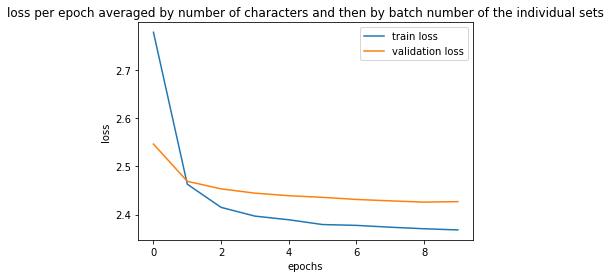

In [12]:
epoch_range = [plot_step_size*i for i in range(0,len(plot_val))]

plt.plot(epoch_range,plot_train)
plt.plot(epoch_range,plot_val)

plt.legend(['train loss', 'validation loss'])

plt.title('loss per epoch averaged by number of characters and then by batch number of the individual sets')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show;

Discussion training and validation process: With a batch_size of 256 and also other high valued inputs the model gets fastly computational heavy. It is not possible for my notebook to finish one epoch. Therefore, the hypterparameters were lowered in their values (see code box above). This gives us following plot:

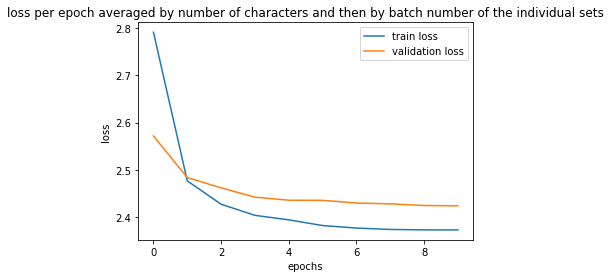

Even with few epochs you can observe the trend that the losses decrease. At the fist epoch the loss for the validation set is even smaller than the one of the training set. That could be simply because the model was updated once more for the validation set. 

## Exercise 6: Top-$k$ Accuracy

Write a function `topk_accuracy` that takes a list of integers $k$, a model, and a data loader and returns the top-$k$ accuracy of the model on the given data set for each $k$. A sample is considered to be classified correctly if the true label appears in the top-$k$ classes predicted by the model. Then load the best model from the previous exercise using `torch.load` and plot its top-$k$ accuracy as a function of $k$ for all possible values of $k$. Discuss the results. 

"This metric computes the number of times where the correct label is among the top k labels predicted (ranked by predicted scores)" (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.top_k_accuracy_score.html).

In [14]:
########## YOUR SOLUTION HERE ##########
def topk_accuracy(k_list:list, model, data_loader):
    
    acc_list = [] # later returned
    
    # k (as element of k_list) gives us the number of top predictions to be considered.
    
   # for single_batch_ind in range(int(number_samples/batch_size)+1):
        
    # reuse from exercise 5:
    mini_batch = next(iter(data_loader))

    my_logits = model.forward(mini_batch)
    
    
    my_logits = my_logits[:,:-1,:]
    # compute loss:

     #pred = torch.swapaxes(my_logits[:,:-1,:], 1, 2) # lstm makes at time 
    # t preditiction for time t+1.
    # bring shape to: minibatch x tensor_size x dimensions

    targets =  mini_batch[:,1:] # ignore the first character of each sample


    # compute the top k accuracy for full dataset:
    acc_matrix = torch.zeros((my_logits.shape[0],my_logits.shape[1],len(k_list)))
    
    
    
    if {1} == set(np.array(k_list[1:])-np.array(k_list[:-1])): # then we have a stepwise increasing k

        my_logits_stored = my_logits.clone().detach()

        k_torch = torch.zeros((my_logits_stored.shape[0],my_logits_stored.shape[1]))

        for k_ind, k in enumerate(np.array(k_list)): # k as number of prediction candidates to use
        
            # draw out k maxima for each entry:
            max_val, max_ind = torch.max(my_logits_stored,dim=2)

            true_values = torch.where(max_ind==targets,max_ind,-1) # values where targets and the 
            # prediction
            # (max_ind gives us the index of alphabet position which is also the belonging int) get 
            # int value, else when no match -1. For the next round, where the second most probable 
            # prediction values are looked at, do the same principle
            
            # replace all 0-s where we have a true prediction with 1:
            k_torch[true_values>-1] = 1 

            # make sure that in next loop lower maximum will be chosen:
            for s1 in range(k_torch.size(dim=0)):
                for s2 in range(k_torch.size(dim=1)):
                    belonging_max = max_ind[s1,s2]
                    my_logits_stored[s1][s2][belonging_max]= float('-inf') # so the upcoming max selections
                    # are not selecting the already chosen max
  
            # cut of maxima already used to get second/third/... highest maxima

            # after full k is processed, we can compute the final accuracy for this k:
            number_entries = k_torch.size(dim=0) * k_torch.size(dim=1)
            acc = int(torch.sum(k_torch)) / number_entries
            acc_list.append(acc)
        
    
    
    else:
    
        for k_ind, k in enumerate(np.array(k_list)): # k as number of prediction candidates to use
            my_logits_stored = my_logits.clone().detach()
            k_torch = torch.zeros((my_logits_stored.shape[0],my_logits_stored.shape[1]))

            # draw out k maxima for each entry:
            for i in range(k):
                max_val, max_ind = torch.max(my_logits_stored,dim=2)

                true_values = torch.where(max_ind==targets,max_ind,-1) # values where targets and the 
                # prediction
                # (max_ind gives us the index of alphabet position which is also the belonging int) get 
                # int value, else when no match -1. For the next round, where the second most probable 
                # prediction values are looked at, do the same principle
                #f=torch.masked_select(k_torch, true_values>-1)

                # replace all 0-s where we have a true prediction with 1:
                k_torch[true_values>-1] = 1 

                # make sure that in next loop lower maximum will be chosen:
                for s1 in range(k_torch.size(dim=0)):
                    for s2 in range(k_torch.size(dim=1)):
                        belonging_max = max_ind[s1,s2]
                        my_logits_stored[s1][s2][belonging_max]= float('-inf') # so the upcoming max selections
                        # are not selecting the already chosen max

                # cut of maxima already used to get second/third/... highest maxima

            # after full k is processed, we can compute the final accuracy for this k:
            number_entries = k_torch.size(dim=0) * k_torch.size(dim=1)
            acc = int(torch.sum(k_torch)) / number_entries
            acc_list.append(acc)



    return acc_list          
            

In [15]:
# Use when not executing exercise 5:
sequence_length = 100
batch_size = 16 # 256
embedding_dim = 8
hidden_dim = 50 # 512
learning_rate = 1e-3
num_epochs = 10 # 100
# --> global variables: also usable within functions!

np.random.seed(0)

# create data loader:
data_val = TestDataset('trump/trump_val.txt', sequence_length) # Encoder() already included
number_samples = data_val.__len__()
to_set_alphabet = data_val.__getitem__(0)

val_loader = DataLoader(data_val, batch_size = number_samples,# instead full data used batch_size, 
                          shuffle=True) # splits data by batch_size

# Instanciate and load model:
model = NextCharLSTM(len(alphabet)+1, embedding_dim, hidden_dim)
#model.load_state_dict(torch.load('best_lstm_model.pt'))
loading = torch.load('best_lstm_model.pt')
model.load_state_dict(loading['model_state_dict'])


# create k_list:
k_list = [i for i in range(1,len(alphabet)+1)] # the accuracy should be 1 when the full size of the alphabet 
# reached because all predictions are contained then such that the true value has to be under them.


k_acc = topk_accuracy(k_list, model, val_loader)
k_acc

[0.2649803115904811,
 0.4152542372881356,
 0.522085259373395,
 0.6156908063687725,
 0.6779661016949152,
 0.7318524225303886,
 0.7717000513610683,
 0.8024738914569423,
 0.831236089710666,
 0.8581578496832735,
 0.8816555384351995,
 0.8991611025509331,
 0.917522684471837,
 0.9311761684643041,
 0.9462420818353022,
 0.9569423043999316,
 0.9664441020373223,
 0.9710665981852422,
 0.9767591165896251,
 0.9838212634822804,
 0.9870741311419278,
 0.9897705872282143,
 0.9936226673514809,
 0.9972607430234549,
 0.9980311590481082,
 0.9983307652799178,
 0.9989727786337956,
 0.9992295839753467,
 0.9994007875363807,
 0.9996147919876733,
 0.9997859955487074,
 0.9998715973292245,
 0.9999143982194829,
 0.9999571991097415,
 0.9999571991097415,
 0.9999571991097415,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
import matplotlib.pyplot as plt


plt.plot(k_list,k_acc)

plt.title('Top-k-accuracy over different k for validation set')
plt.xlabel('k: number of allowed prediction candidates')
plt.ylabel('Top-k-accuracy in range [0,1]')
plt.show;

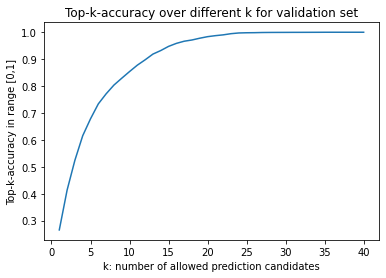

k_acc shows us that we reach a accuracy of 80 % with k=7. That means that the true value is one of the 7 most probable prediction candidates. That's quite good concerning that we have an alphabet of length=40 and the fact that in exercise 5 only a very small model was trained over few epochs (10).<br>
Furthermore, when we concern k=40 what is the alphabet size the model has to have an accuracy of 1 because it is allowed to predict any character out of the alphabet. That was the case (last entry of k_acc) and therefore no huge bug seems to be into the it.

## Exercise 7: Gumbel-Max Character Sampling

In this exercise we utilize the trained network to generate novel text. To do this, take some string of seed text, which you can choose freely, and feed it to the network. For each subsequent character, the model outputs logits $z = (z_1, \dots, z_K)^\top$, where $K$ is the alphabet size. 

Use the Gumbel-Max trick to sample from the categorical distribution parameterized by 
$$
\pi_k = \frac{e^{z_k / \tau}}{\sum_{j=1}^K e^{z_j / \tau}} \quad \text{where} \quad \tau > 0 
$$
is the temperature. For $\tau \to 0$ we approach the one-hot distribution, whereas for $\tau \to \infty$ we approach the uniform distribution. The Gumbel-Max trick says that the random variable 
$$
Y = \arg \max_{k \in 1, \dots, K} (z_k / \tau + \xi_k) 
$$
follows a categorical distribution parameterized by $\pi_1, \dots, \pi_K$, where $\xi_k$ is drawn independently from the standard Gumbel distribution.

Implement next-character sampling using the Gumbel-Max trick. Try out different values of $\tau$ and see which work best. 

In [16]:
########## YOUR SOLUTION HERE ##########
my_sample = 'Hello, welcome to my speech to present the seventh exercise to you. I hope you enjoy my solution. As you can see'

# convert text into torch:
encoder = Encoder(alphabet) # reuse alphabet variable from previous exercises
torch_input = encoder.__call__(my_sample)
torch_input_orig = torch_input.clone().detach()

model_out = model.forward(torch_input) # model from exercise 7

# draw epsilons, one per alphabet letter, from the standard gumbel distribution:
rng = np.random.default_rng(seed=0)
epsilon_ar = rng.gumbel(size=len(alphabet)+1)
epsilon_torch = torch.tensor(epsilon_ar)

tau_list = [0.001, 0.01, 0.2, 0.4, 1, 10, 100, 1000, 10000, 10000000000]

final_pred_tau = []
for tau in tau_list:
    
    final_pred_string = ''
    torch_input = torch_input_orig.clone().detach()
    
    model_out = model.forward(torch_input) # model from exercise 7 # n

    for T_plus in range(20): # predict 20 characters which produce new text
        
        # Get Y - choose the predictions:
        # look at the last output of model:
        Y = model_out[-1,:]/tau + epsilon_torch # each column gets same epsilon value
        max_val, max_ind = torch.max(Y.unsqueeze(1),dim=0) # get for each character the prediction candidate
        
        chosen_pred = max_ind
        
        # convert the last model output's top candidate into str which is our next character:
        pred_string = encoder.__call__(chosen_pred)
        final_pred_string += pred_string
        
        # convert input to next time step such we can make prediction that advances our original input
        # string:
        torch_input = torch.cat((torch_input.unsqueeze(1),chosen_pred.unsqueeze(1))).flatten()
        model_out = model.forward(torch_input) # model from exercise 7
    
    final_pred_tau.append(final_pred_string)
    
print('predictions for different taus: ' ,final_pred_tau)

predictions for different taus:  [' the the the the the', ' the the the the the', ' t t t t t t t t t t', ' lllllllllllllllllll', 'llllllllllllllllllll', 'llllllllllllllllllll', 'llllllllllllllllllll', 'llllllllllllllllllll', 'llllllllllllllllllll', 'llllllllllllllllllll']


## Exercise 8: Huffman Coding using LSTM

*Thanks to Philipp Renz who had this idea.*

The Huffman code is an algorithm to compress data. It encodes symbols with different lengths depending on their frequencies. It assigns a short code to frequent symbols and a longer code to rare symbols to minimize the average code length. We provide you with an implementation that given a list of frequencies `freqs` returns a list of their respective binary codes as strings in the same order. In fact, `freqs` may contain any real numbers. 

With a model that predicts the next symbol we can achieve even shorter codes. At every time step we can use the predicted probabilities as frequencies for the Huffman code. That is, we use a new code at every time step. This code is governed by the model's belief what the next symbol will be. If the model predictions are good, we will mostly use very short codes.

First, determine the average code length per symbol on the validation set using frequencies determined on the training set. 
Then, use the prediction probabilities of your trained LSTM and determine the average code length per symbol on the validation set using an adaptable code. Add a temperature to the softmax and tune it. How many bits per symbol can you save by using the LSTM and what is the optimal temperature? 

In [ ]:
from heapq import heapify, heappop, heappush

def huffman_code(freqs):
    # e.g. huffman_code([0.2,0.8]) returns ['0', '1']
    # e.g. huffman_code([.2,.3,.4,.1]) returns ['111', '10', '0', '110'] -> less probable values 
    # get longer binary strings
    
    """This function turns a list of frequencies into a Huffman code. """
    heap = list(zip(freqs, [(i,) for i in range(len(freqs))]))
    heapify(heap)
    code = [''] * len(freqs)
    
    while len(heap) > 1:
        freq0, idx0 = heappop(heap)
        freq1, idx1 = heappop(heap)
        heappush(heap, (freq0 + freq1, idx0 + idx1))
        
        for i in idx0:
            code[i] = '0' + code[i]
        
        for i in idx1:
            code[i] = '1' + code[i]
    
    return code

########## YOUR SOLUTION HERE ##########


In [ ]:
code_time_adapt = False # True: use timpe adaptable code after 'This code is governed by the model's 
# belief what the next symbol will be. If the model predictions are good, we will mostly use very 
# short codes.'
# Nevertheless, after the description above only False makes sense.

In [ ]:
from collections import defaultdict
def def_value():
    return  '' # values for keys that are not present in the dictionary


sequence_length = 100
train_data = TestDataset('trump/trump_train.txt', sequence_length) # Encoder() already included
number_samples = train_data.__len__()
train_loader = DataLoader(train_data, batch_size = number_samples, 
                          shuffle=True) # splits data by batch_size
mini_batch = next(iter(train_loader)) 

val_data = TestDataset('trump/trump_val.txt', sequence_length) # Encoder() already included
number_samples_val = val_data.__len__()
val_loader = DataLoader(val_data, batch_size = number_samples_val, 
                          shuffle=True) # splits data by batch_size
mini_batch_val = next(iter(val_loader)) 


temp_list = [0.1,0.5,1,10,100,1000,10000,100000]
soft = nn.Softmax(dim=1)

alphabet_ap = alphabet + '~' # ~ stands for all symbols which not appear in the alphabet, e.g. Ãœ
alphabet_list = list(alphabet_ap)

total_len, number_entries, code_lengths = 0,0,[]
    
# Now we have data ready to be fed into a forward pass - get the output for one batch:
my_logits = model.forward(mini_batch)

ex7 = True 

# 1. get the max of each entry. Choose max along dim=2:
if code_time_adapt == False:
    work_matrix_old = torch.zeros(my_logits.shape)
    max_val, max_ind = torch.max(my_logits,dim=2)

    # Fill the work_matrix with ones where the max of each character lays:
    for s1 in range(work_matrix_old.size(dim=0)):
        for s2 in range(work_matrix_old.size(dim=1)):
            belonging_max = max_ind[s1,s2]
            work_matrix_old[s1][s2][belonging_max]= 1
    # 2. sum up work_matrix along the single time points to get for each alphabet letter the number of 
    # times it appears at a certain time point:
    work_matrix_old = torch.sum(work_matrix_old, dim=0)

else:
    loss_matrix = epoch(data_loader=train_loader, my_lstm=model, optimizer=None)
    work_matrix_old = loss_matrix # new 27.12.22
    dict_keys_val_adapt = epoch(data_loader=val_loader, my_lstm=model, optimizer=None)


    
for temp in temp_list:  

    if code_time_adapt == False:
        
        # 3. Calculate the softmax conercerning temp along the alphabet dimension to get the probability 
        # distirbution for each letter at a time point t:
        work_matrix = soft(work_matrix_old/temp) # after 
        # https://datascience.stackexchange.com/questions/58376/gumbel-softmax-trick-vs-softmax-with-temperature

        Time = work_matrix.shape[0]
        
    else:

        Time = work_matrix_old.shape[1]
        
    # 4. get the code for the softmax work_matrix for each time step becaue ever time step we shall 
    # derive new code:
    for time in range(Time):

        # 5. create dictionary which stores the letters as keys and the code values as values:
        if code_time_adapt == False:
            code = huffman_code(work_matrix[time,:])
            translate_dict = dict(zip(alphabet_list,code))
        else:
            code = huffman_code(work_matrix_old[:,time])
            
            translate_dict = dict(zip([np.round(ele.item(),2) for ele in work_matrix_old[:,time]],code))
            translate_dict = defaultdict(def_value, translate_dict)
            
        # 6. transform the validation letters into code. Dont forget that the batch is saved with ints
        # encoding instead of the letters, therfore transform.:
        if code_time_adapt == False:
            dict_keys = mini_batch_val[:,time].detach().numpy()

            val_code_time_t = [translate_dict[alphabet_ap[letter]] for letter in dict_keys]
        else:

            dict_keys_val_adapt_time_t = dict_keys_val_adapt[:,time]
            
            val_code_time_t = [translate_dict[np.round(loss.item(),2)] for loss in dict_keys_val_adapt_time_t]

        # 7. get the average length by adding up all the strings and then divide it by number of related entries:
        full_len_time_t = len(''.join(val_code_time_t))
        number_entries_time_t = len(val_code_time_t)
        average_len_time_t = full_len_time_t / number_entries_time_t 

        total_len += full_len_time_t
        number_entries +=  number_entries_time_t
        code_lengths.append(average_len_time_t)
        
        if code_time_adapt:
            break
        
    total_average_len = full_len_time_t / number_entries_time_t 
    print('Average code length over whole validation set: ', total_average_len, 'by temp = ', temp)



For non time adapting process (code_time_adapt=False): One bit describes 0/1 in the binary encoding. The average bit number per symbol is then the average code length which is given as the output above.<br>
There you can see that the optimal temperature seems to lay around 1000 because the average code length per symbol is shortest there.<br>

Notebook done by Nina Braunmiller - k11923286